In [1]:
#from preprocessing import *
#from visualization_utils import *
from gensim.models import Word2Vec
import sys
import pandas as pd

c:\users\costanza\appdata\local\programs\python\python37-32\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
"""PREPROCESSING FUNCTIONS"""

from gensim.parsing.preprocessing import preprocess_string
import re
import string

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric


def remove_ip(s):
    # Replace all ip adresses with '<ip>' tag
    ip_regexp = r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b"
    return re.sub(ip_regexp, '<ip>', s)


def remove_email(s):
    # Replace all email adresses with '<email>' tag
    email_regexp = r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})"
    return re.sub(email_regexp, '<email>', s)


def remove_mailto(s):
    # Replace all "<mailto:<email>>" with <email>. Email adresses should be replaced by remove_email first.
    return s.replace("<mailto:<email>>", "<email>")


def remove_url(s):
    # Replace all url's with '<url>' tag
    url_regexp = r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    s = re.sub(url_regexp, '<url>', s)
    # Sometimes url's are inside <> so we need to replace <<url>> with <url>
    return s.replace("<<url>>", "<url>")


def remove_punc(s, exceptions):
    # Remove all punctuation from string with exceptions in list exceptions
    remove = string.punctuation
    for exception in exceptions:
        remove = remove.replace(exception, "")
    # Create the pattern
    pattern = r"[{}]".format(remove)

    return re.sub(pattern, "", s)


def remove_custom_stopwords(s, stopwords):
    for stopword in stopwords:
        s = s.replace(stopword, "")
    return s


def lower_case(s):
    return s.lower()


def preprocess_sentence_fn(s):
    # Preprocess a single sentence to a list of tokens
    punc_exceptions = ['<', '>']
    custom_stopwords = ['dear', 'sincerely', 'thanks', 'yours', 'regards']

    filters = [lower_case,
               remove_ip,
               remove_email,
               remove_mailto,
               remove_url,
               lambda x: remove_punc(x, punc_exceptions),
               remove_stopwords,
               lambda x: remove_custom_stopwords(x, custom_stopwords),
               strip_multiple_whitespaces,
               stem_text,
               strip_numeric]
    out = preprocess_string(s, filters=filters)

    return out


def preprocess_docs_fn(docs):
    # Apply preprocess_sentence_fn to a list of sentances (docs) to get a list of lists
    return [preprocess_sentence_fn(s) for s in docs]


In [26]:
"""VISUALIZATION UTILS FUNCTIONS"""

from sklearn.manifold import TSNE
from matplotlib import pyplot
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


#function to keep track from where the word is coming from
def belongs_to(word, faq_ques_docs, faq_ans_docs, ticket_content_docs):
    faq_ques = False
    faq_ans = False
    tic = False
    faq_ques = any(word in x  for x in faq_ques_docs)
    faq_ans = any(word in x  for x in faq_ans_docs)
    tic = any(word in x  for x in ticket_content_docs)
    tot = (faq_ques or faq_ans) and tic
    if tot:
        out = 'g'
    else:
        if tic:
            out = 'y'
        else: out = 'b'
    return(out)

#function to compute and plot PCA
def pca_plot(tokens, col, fname, n_comp):
    pca = PCA(n_components=n_comp)
    pca_tokens = pca.fit_transform(tokens)

    if n_comp == 2:
        pyplot.figure(figsize=(16, 16))
        pyplot.scatter(pca_tokens[:, 0], pca_tokens[:, 1], c=col, alpha=.1)
        name = 'plots/' + str(fname) + '.pca.png'
        pyplot.savefig(name)
        # plt.show()
    else:
        fig = pyplot.figure(figsize=(16, 16))
        ax = Axes3D(fig)
        ax.scatter(pca_tokens[:, 0], pca_tokens[:, 1], pca_tokens[:, 2], c=col, alpha=.2)
        name = 'plots/' + str(fname) + '.pca.png'
        pyplot.savefig(name)
        # pyplot.show()

#function to compute and plot TSNE
def tsne_plot(tokens, col, fname, perp, n_iter, n_comp):
    print('Computing TSNE model. This will take a while... have a cup of tea in the meanwhile')
    pca = PCA(n_components=50)
    pca_tokens = pca.fit_transform(tokens)
    tsne_model = TSNE(perplexity=perp, n_components=n_comp, init='pca', n_iter=n_iter)
    new_values = tsne_model.fit_transform(pca_tokens)

    if n_comp == 2:
        pyplot.figure(figsize=(16, 16))
        pyplot.scatter(new_values[:, 0], new_values[:, 1], c=col, alpha=.2)
        name = 'plots/' + str(fname) + '.perp' + str(perp) + '.iter' + str(n_iter) + '.png'
        pyplot.savefig(name)
        # plt.show()
    else:
        fig = pyplot.figure(figsize=(16, 16))
        ax = Axes3D(fig)
        ax.scatter(new_values[:, 0], new_values[:, 1], new_values[:, 2], c=col, alpha=.2)
        name = 'plots/' + str(fname) + '.perp' + str(perp) + '.iter' + str(n_iter) + '.png'
        pyplot.savefig(name)
        # pyplot.show()

In [21]:
# Function for visualizing embedding model
# run python visualization.py [model name].model

#save from input
#fname = sys.argv[1]  #embedding model
fname = 'word2vec.model'

#PARAMETERS for TSNE
perp = [15, 20] #tsne perplexity
#[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_iter = 250 #tsne iterations
n_comp = 2 #do you want a 2D or 3D visualization?

In [3]:
#load the embedding model
model = Word2Vec.load('../../code/embedding/models/word2vec.model')

# Read in the data
ticket_dat = pd.read_csv('../../data/ticket_dat.csv')
faq_dat = pd.read_csv('../../data/faq_dat.csv')

# Replace the NaNs
ticket_dat.fillna('', inplace=True)
faq_dat.fillna('', inplace=True)

# Make sentences into
faq_ques = list(faq_dat.ques_content_translation)
faq_ques_docs = preprocess_docs_fn(faq_ques)

faq_ans = list(faq_dat.ans_content_translated)
faq_ans_docs = preprocess_docs_fn(faq_ans)

ticket_content = list(ticket_dat.content_translated)
ticket_content_docs = preprocess_docs_fn(ticket_content)

all_docs = faq_ques_docs + faq_ans_docs + ticket_content_docs

In [12]:
#unwrapping the embedding model
labels = []
tokens = []
col = [0]*len(model.wv.vocab)
print('Storing from which dataset words come from...')
i = 0
for word in model.wv.vocab:
    #print(i)
    tokens.append(model[word])
    labels.append(word)
    col[i] = belongs_to(word, faq_ques_docs, faq_ans_docs, ticket_content_docs)
    i += 1

Storing from which dataset words come from...


c:\users\costanza\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [18]:
col.count('b')

508

Working on PCA plot


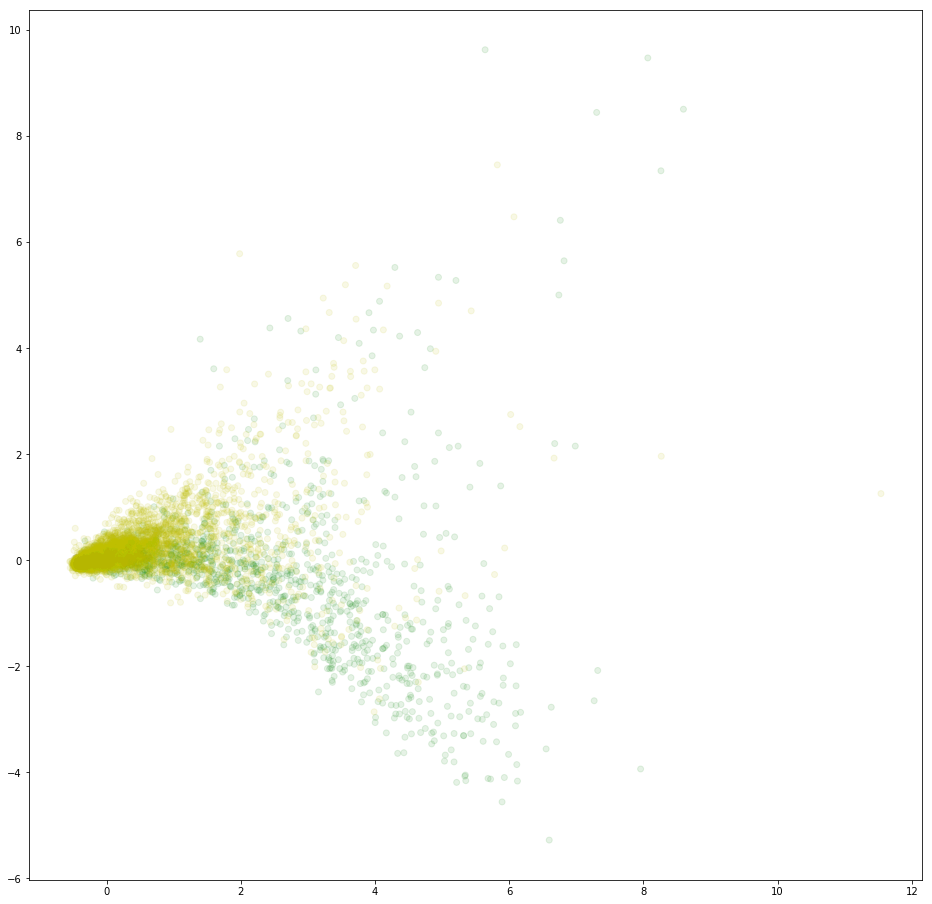

In [27]:
#compute and plot PCA
print('Working on PCA plot')
pca_plot(tokens, col, fname, n_comp)

CURRENTLY WORKING ON TSNE WITH PERPLEXITY = 15
Computing TSNE model. This will take a while... have a cup of tea in the meanwhile
CURRENTLY WORKING ON TSNE WITH PERPLEXITY = 20
Computing TSNE model. This will take a while... have a cup of tea in the meanwhile


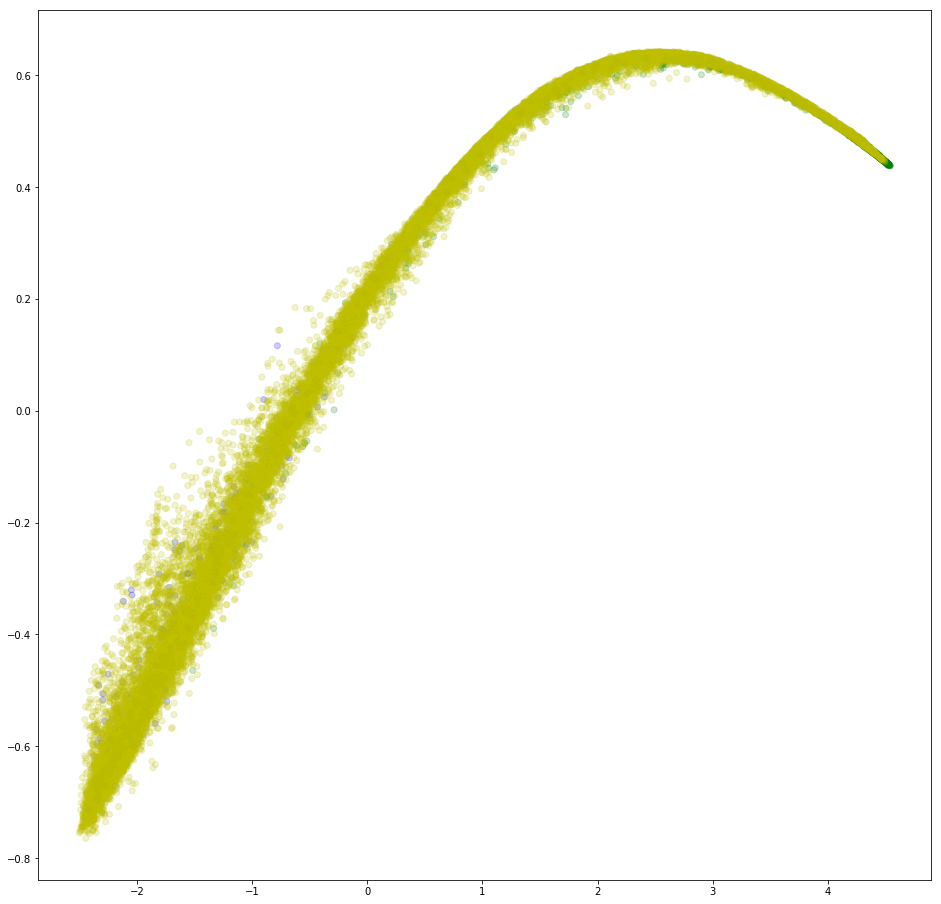

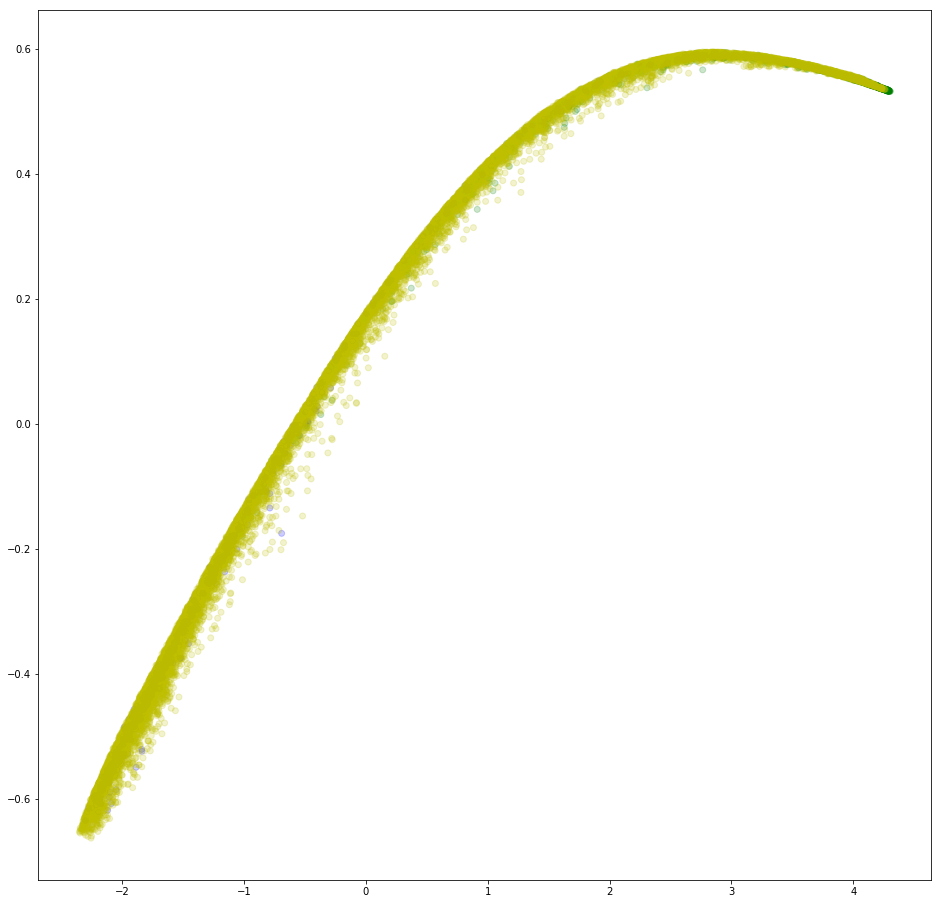

In [23]:
#compute and plot TSNE
for i in perp:
    print('CURRENTLY WORKING ON TSNE WITH PERPLEXITY = ' + str(i))
    tsne_plot(tokens=tokens, col=col, fname=fname, perp=i, n_iter=n_iter, n_comp=n_comp)

In [29]:
pca = PCA(n_components=2)
pca_tokens = pca.fit_transform(tokens)

In [31]:
print(pca_tokens[0:10])
print(len(pca_tokens))

[[ 5.15591059 -2.16629981]
 [ 2.74173038 -0.19458963]
 [ 5.57015471 -2.57520612]
 [ 3.83092126 -2.32046702]
 [ 5.39734097 -2.85923566]
 [ 3.80562261 -1.9448029 ]
 [-0.35243165 -0.04946014]
 [ 2.72365166  0.11236801]
 [-0.24850047  0.0150139 ]
 [ 4.17416298 -2.38375587]]
20922


In [33]:
pca_tokens_rev = pca_tokens[::-1]

In [41]:
print(pca_tokens_rev[20911:20922])

[[ 3.04707693 -1.27084176]
 [ 4.17416298 -2.38375587]
 [-0.24850047  0.0150139 ]
 [ 2.72365166  0.11236801]
 [-0.35243165 -0.04946014]
 [ 3.80562261 -1.9448029 ]
 [ 5.39734097 -2.85923566]
 [ 3.83092126 -2.32046702]
 [ 5.57015471 -2.57520612]
 [ 2.74173038 -0.19458963]
 [ 5.15591059 -2.16629981]]


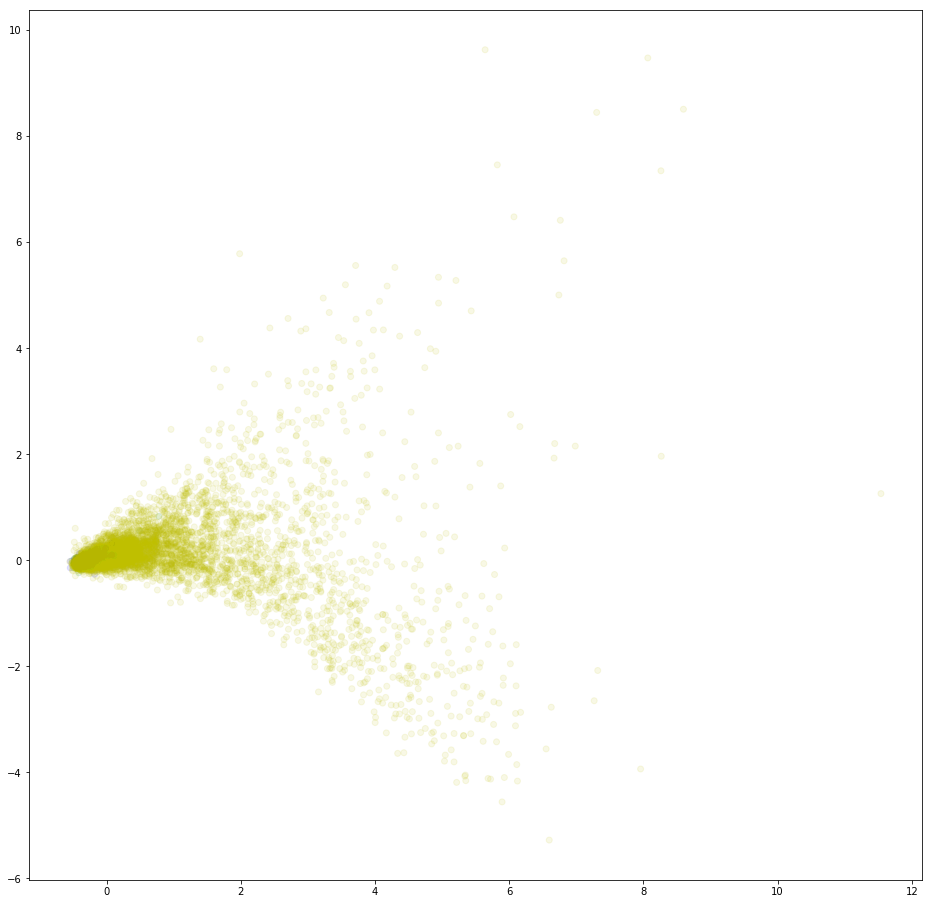

In [47]:
pyplot.figure(figsize=(16, 16))
pyplot.scatter(pca_tokens_rev[:, 0], pca_tokens_rev[:, 1], c=col, alpha=.1)
#name = 'plots/' + str(fname) + '.pca.png'
#pyplot.savefig(name)

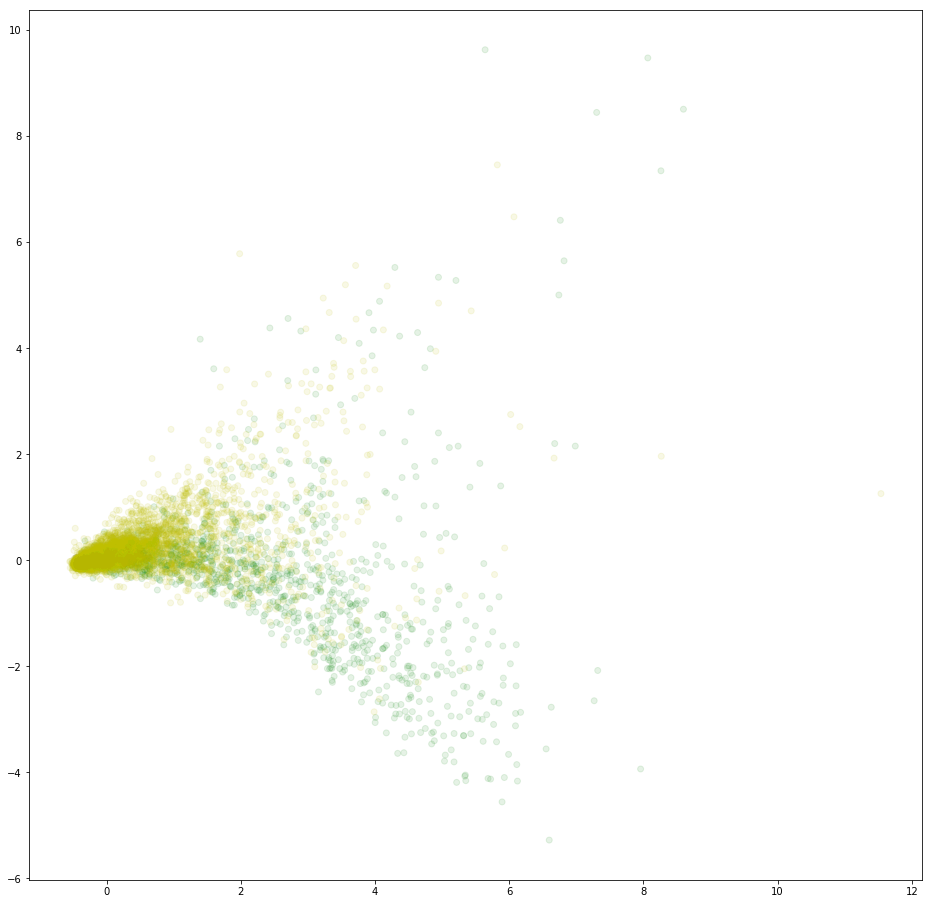

In [48]:
pyplot.figure(figsize=(16, 16))
pyplot.scatter(pca_tokens[:, 0], pca_tokens[:, 1], c=col, alpha=.1)
#name = 'plots/' + str(fname) + '.pca.png'
#pyplot.savefig(name)